In [1]:
import matplotlib.pyplot as plt
import numpy as np
from tomo2mesh.fbp.subset import recon_all_gpu
from tomo2mesh import DataFile
import dxchange
from tomo2mesh import viewer
import cupy as cp
from tomo2mesh.misc.voxel_processing import modified_autocontrast
from tomo2mesh.misc.viewer import add_scalebar
from cupyx.scipy import ndimage
from skimage.filters import threshold_otsu
from cupyx.scipy.ndimage import binary_opening
from tomo2mesh.structures.voids import Voids
from tomo2mesh.misc.voxel_processing import TimerGPU
from tomo2mesh.fbp.subset import recon_patches_3d

spefile module not found
netCDF4 module not found
EdfFile module not found
astropy module not found
olefile module not found


In [2]:
def find_solder_bumps(projs, theta, center, b, b_K, pixel_size, approx_size):
    t_gpu = TimerGPU("secs")
    memory_pool = cp.cuda.MemoryPool()
    cp.cuda.set_allocator(memory_pool.malloc)

    # fbp
    t_gpu.tic()

    raw_data = projs[::b_K,::b,::b], theta[::b_K,...], center/b
    V = recon_all_gpu(*raw_data, dark_flat = (dark[::b,::b],flat[::b,::b]), sinogram_order=False)
    V[:] = ndimage.gaussian_filter(V,0.5)    
    
    # binarize
    voxel_values = V.reshape(-1).get()
    rec_min_max = modified_autocontrast(voxel_values, s=0.01)
    thresh = cp.float32(threshold_otsu(voxel_values))    
    V[:] = (V>thresh).astype(cp.uint8)    
    V[:] = binary_opening(V, structure = cp.ones((9,9,9), dtype = cp.uint8))    
    t_rec = t_gpu.toc('COARSE RECON')

    # connected components labeling
    t_gpu.tic()
    V = cp.array(V, dtype = cp.uint32)
    V[:], n_det = ndimage.label(V,structure = cp.ones((3,3,3),dtype=cp.uint8))    
    voids_b = Voids(pad_bb = 3).count_voids(V.get(), b, 0)    
    voids_b.select_by_size(approx_size, pixel_size_um = pixel_size)
    t_label = t_gpu.toc('LABELING')
    
    voids_b["rec_min_max"] = rec_min_max
    voids_b.compute_time = {"reconstruction" : t_rec, "labeling" : t_label}
    voids_b["thresh_otsu"] = thresh

    del V
    memory_pool.free_all_blocks()    
    return voids_b

In [3]:
fpath = '/data02/MyArchive/tomo_datasets/Sigray_SSD/Tekawade_SSD_050.h5'
# 3201, 2426, 3232
center = 1615.5
pixel_size = 0.6722679580997339
b_K = 16
b = 16
projs, flat, dark, theta = dxchange.read_aps_32id(fpath)
flat = np.median(flat, axis = 0).astype(np.float32)
dark = np.median(dark, axis = 0).astype(np.float32)
projs = projs.astype(np.float32)

In [4]:
ntheta, nz, n = projs.shape
projs = projs[:, :-int(nz%128), :-int(n%128)].copy()
flat = flat[:-int(nz%128), :-int(n%128)].copy()
dark = dark[:-int(nz%128), :-int(n%128)].copy()

In [5]:
bumps = find_solder_bumps(projs, theta, center, b, b_K, pixel_size, 50.0)

	TIME: COARSE RECON 0.39 secs
	STAT: voids found - 6
	STAT: size thres: 4.65 pixel length for 50.00 um threshold
	TIME: LABELING 0.02 secs


In [6]:
surf = bumps.export_void_mesh_with_texture("sizes")
surf.write_ply('/data01/tmp_ply/SSD_vis.ply')

	TIME: compute void mesh 0.41 secs


In [7]:
grid, r_fac = bumps.export_grid(32)

	STAT: 1/r value: 9.289


In [8]:
cp._default_memory_pool.free_all_blocks(); cp.fft.config.get_plan_cache().clear()

In [27]:
x_grid, grid = recon_patches_3d(projs, theta, center, grid, sinogram_order=False)

100%|███████████████████████████████████████████| 51/51 [01:30<00:00,  1.77s/it]


In [28]:
bumps["thresh_otsu"]

0.43301052

In [29]:
# x_grid = (np.clip(x_grid, *bumps["rec_min_max"]) - bumps["rec_min_max"][0])/(bumps["rec_min_max"][1] - bumps["rec_min_max"][0])

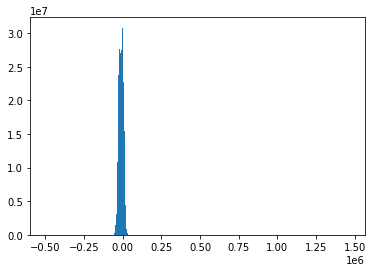

In [30]:
_ = plt.hist(x_grid[:,::2,::2,::2].reshape(-1), bins = 500)

In [31]:
y_grid = (x_grid > bumps["thresh_otsu"]).astype(np.uint8)

In [32]:
bumps_hr = Voids().import_from_grid(bumps, y_grid, grid)

In [33]:
len(bumps_hr)

6

array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>], dtype=object)

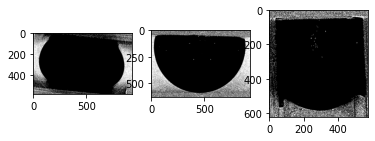

In [37]:
viewer.view_midplanes(vol = bumps_hr["x_voids"][1])

array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>], dtype=object)

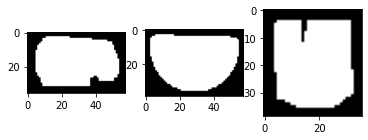

In [38]:
viewer.view_midplanes(vol = bumps["x_voids"][1])

In [ ]:
Vfill = np.empty((projs))
grid.fill_patches_in_volume(x_grid, )

##### 